# Result figures for *Enhanced spatio-temporal electric load forecasts with less data using active deep learning*

---

## Overview
1. Import and test results
2. Numeric results
3. Space and time selection
4. Budget vs. accuracy
5. Training and validation losses against unqueried candidates
6. Validation losses against all candidates
7. Query sequence importance
8. Exemplar predictions

In this notebook session, we summarize and visualize the experimental results of our manuscript. We start with selecting the respective set of experimental results that we want to compare to each other, and import a number of packages that we use throughout this notebook session. 

In [7]:
### Set some parameters ###

# choose which results dataset you want to process
profile_set = 'profiles_100'

# prediction types to consider
PRED_TYPE_LIST = [
    'spatial',
    'temporal',
    'spatio-temporal'
]

# parameter constellations to consider
PARAMETER_LIST = [
    'delta0_valup0', 
    'delta0_valup1', 
    'delta1_valup0', 
    'delta1_valup1'
]


# choose which AL variables to plot. Choose from 'X_t', 'X_s1', 'X_st', 'X_joint', 'X_(t,s)', 'Y_(t,s)'
AL_VARIABLES = [
#    'X_t', 
#    'X_s1', 
    'X_st', 
    'X_(t,s)', 
    'Y_hat_(t,s)', 
    'Y_(t,s)'
]


# choose which AL variables to plot. Choose from 'X_t', 'X_s1', 'X_st', 'X_joint', 'X_(t,s)', 'Y_(t,s)'
AL_VARIANTS = [
    'rnd d_c', 
    'max d_c', 
    'min d_c', 
    'avg d_c'
]


# create figure sub title list
fig_title_list = [
    'a.', 'b.', 'c.', 'd.', 'e.', 'f.', 'g.', 'h.',
    'i.', 'j.', 'k.', 'l.', 'm.', 'n.', 'o.', 'p.',
    'q.', 'r.', 's.', 't.', 'u.', 'v.', 'w.', 'x.'
]

# set width
WIDTH_FACTOR = 8

# set universal fontsize
FONTSIZE = 20

### Import packages ###

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import math
import tensorflow as tf
import numpy as np
from PIL import Image
import random


### Provide import paths and file names ###

# path to results folder
path_to_results = '../results/' + profile_set + '/'

# path to initially trained encoders and prediction model
path_to_encoders = path_to_results + 'encoder weights/'

# path to numeric result values
path_to_values = path_to_results + 'values/'

# path to unseen test samples
path_to_samples = path_to_results + 'samples/'

# path to models 
path_to_models = path_to_results + 'models/'

# individual file names
hyper_filename = 'hyper.csv'
results_filename = 'results.csv'
seqimportance_filename = 'sequence_importance.csv'
spacetime_selection_filename = 'spacetime_selection.csv'
budgetaccuracy_filename = 'budget_vs_accuracy.csv'

initial_model_filename = 'initial.h5'
PL_model_filename = 'PL.h5'

### Provide export paths and file names ###

# path to saving result figures
path_to_saving_figures = path_to_results + 'figures/'

if not os.path.exists(path_to_saving_figures):
    os.mkdir(path_to_saving_figures)

# path to subfolder for saving spacetime point selection
path_to_saving_spacetime = path_to_saving_figures + 'space-time selection/'

if not os.path.exists(path_to_saving_spacetime):
    os.mkdir(path_to_saving_spacetime)
    
# path to subfolder for saving budgetvsaccuracy
path_to_saving_budgetvsaccuracy = path_to_saving_figures + 'budget vs accuracy/'

if not os.path.exists(path_to_saving_budgetvsaccuracy):
    os.mkdir(path_to_saving_budgetvsaccuracy)
    
# path to subfolder for saving lossesvsunqueried
path_to_saving_lossesvsunqueried = path_to_saving_figures + 'training vs validation losses/'

if not os.path.exists(path_to_saving_lossesvsunqueried):
    os.mkdir(path_to_saving_lossesvsunqueried)
    
# path to subfolder for saving lossesvsall
path_to_saving_lossesvsall = path_to_saving_figures + 'validation against all/'

if not os.path.exists(path_to_saving_lossesvsall):
    os.mkdir(path_to_saving_lossesvsall)
    
# path to subfolder for saving seqimportance
path_to_saving_seqimportance = path_to_saving_figures + 'sequence importance/'

if not os.path.exists(path_to_saving_seqimportance):
    os.mkdir(path_to_saving_seqimportance)
    
# path to subfolder for saving exemplar predictions point selection
path_to_exemplar_predictions = path_to_saving_figures + 'exemplar predictions/'

if not os.path.exists(path_to_exemplar_predictions):
    os.mkdir(path_to_exemplar_predictions)
    
# path to subfolder for saving manuscript figure ADL data selection
path_to_ADL_selection = path_to_saving_figures + 'ADL selection/'

if not os.path.exists(path_to_ADL_selection):
    os.mkdir(path_to_ADL_selection)
    
# path to subfolder for saving manuscript figure ADL data selection
path_to_summary_results = path_to_saving_figures + 'summary results/'

if not os.path.exists(path_to_summary_results):
    os.mkdir(path_to_summary_results)

## 1. Import and test results

Here, we import the results and the hyper parameters that were used in each of our experiment. We check whether all imported results are calculated on the exact same hyper parameters for the hypothesis test.

In [8]:
### Import the results ###

hyper_list = []
results_list = []
seqimportance_list = []
spacetime_selection_list = []
budgetaccuracy_list = []

for index_pred, pred_type in enumerate(PRED_TYPE_LIST):
    
    for index_param, parameter in enumerate(PARAMETER_LIST):
        
        path_to_hyper_parameters = (
            path_to_values 
            + parameter 
            + '/' 
            + pred_type 
            + '/' 
            + hyper_filename
        )
        path_to_results = (
            path_to_values 
            + parameter 
            + '/' 
            + pred_type 
            + '/' 
            + results_filename
        )
        path_to_seqimportance = (
            path_to_values 
            + parameter 
            + '/' 
            + pred_type 
            + '/' 
            + seqimportance_filename
        )
        path_to_spacetime_selection = (
            path_to_values 
            + parameter 
            + '/' 
            + pred_type 
            + '/' 
            + spacetime_selection_filename
        )
        path_to_budgetaccuracy = (
            path_to_values 
            + parameter 
            + '/' 
            + pred_type 
            + '/' 
            + budgetaccuracy_filename
        )
        
        hyper_list.append(
            pd.read_csv(
                path_to_hyper_parameters
            )
        )
        results_list.append(
            pd.read_csv(
                path_to_results
            )
        )
        seqimportance_list.append(
            pd.read_csv(
                path_to_seqimportance
            )
        )
        spacetime_selection_list.append(
            pd.read_csv(
                path_to_spacetime_selection
            )
        )
        budgetaccuracy_list.append(
            pd.read_csv(
                path_to_budgetaccuracy
            )
        )
        
        
### Test correctness of results ###

index_counter = 0

for pred_type in PRED_TYPE_LIST:

    for parameter in PARAMETER_LIST:
        
        delta = int(parameter[5])
        valup = int(parameter[12])
        
        df_hyper = hyper_list[index_counter]
        
        if (df_hyper['red_cand_data_act_lrn'][0] != delta 
            or df_hyper['upd_val_data_act_lrn'][0] != valup):
            
            print(
                'Caution. Wrong assignment of results for', 
                parameter, 
                'and', 
                pred_type
            )

        if index_counter > 0:
            
            if not df_hyper.drop(
                [
                    'pred_list_act_lrn', 
                    'upd_val_data_act_lrn', 
                    'red_cand_data_act_lrn'
                ], 
                axis=1
            ).equals(
                previous_df.drop(
                    [
                        'pred_list_act_lrn', 
                        'upd_val_data_act_lrn', 
                        'red_cand_data_act_lrn'
                    ], 
                    axis=1
                )
            ):
                
                print(
                    'Caution. Results were not calculated on same hyper parameters for', 
                    parameter, 
                    'and', 
                    pred_type
                )
            
        previous_df = df_hyper
        index_counter += 1
        
        display(df_hyper)

,Unnamed: 0,private_data_access,test_sequence_importance,save_act_lrn_results,save_hyper_params,save_act_lrn_models,save_act_lrn_test_sample,pred_list_act_lrn,query_variants_act_lrn,query_variables_act_lrn,...,timestamp_data,time_encoding,spatial_features,histo_bins,grey_scale,down_scale_building_images,meteo_types,history_window_meteo,normalization,standardization
0,0,True,True,True,True,True,True,spatial,rnd d_c,X_st,...,15min,ORD,histogram,100.0,False,NaN,air_density,24.0,True,True
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,min d_c,"X_(t,s)",...,hour,NaN,NaN,NaN,NaN,NaN,cloud_cover,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,max d_c,"Y_hat_(t,s)",...,day,NaN,NaN,NaN,NaN,NaN,precipitation,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,avg d_c,"Y_(t,s)",...,month,NaN,NaN,NaN,NaN,NaN,radiation_surface,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,radiation_toa,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snow_mass,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snowfall,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,temperature,NaN,NaN,NaN
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,wind_speed,NaN,NaN,NaN


,Unnamed: 0,private_data_access,test_sequence_importance,save_act_lrn_results,save_hyper_params,save_act_lrn_models,save_act_lrn_test_sample,pred_list_act_lrn,query_variants_act_lrn,query_variables_act_lrn,...,timestamp_data,time_encoding,spatial_features,histo_bins,grey_scale,down_scale_building_images,meteo_types,history_window_meteo,normalization,standardization
0,0,True,True,True,True,True,True,spatial,rnd d_c,X_st,...,15min,ORD,histogram,100.0,False,NaN,air_density,24.0,True,True
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,min d_c,"X_(t,s)",...,hour,NaN,NaN,NaN,NaN,NaN,cloud_cover,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,max d_c,"Y_hat_(t,s)",...,day,NaN,NaN,NaN,NaN,NaN,precipitation,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,avg d_c,"Y_(t,s)",...,month,NaN,NaN,NaN,NaN,NaN,radiation_surface,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,radiation_toa,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snow_mass,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snowfall,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,temperature,NaN,NaN,NaN
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,wind_speed,NaN,NaN,NaN


,Unnamed: 0,private_data_access,test_sequence_importance,save_act_lrn_results,save_hyper_params,save_act_lrn_models,save_act_lrn_test_sample,pred_list_act_lrn,query_variants_act_lrn,query_variables_act_lrn,...,timestamp_data,time_encoding,spatial_features,histo_bins,grey_scale,down_scale_building_images,meteo_types,history_window_meteo,normalization,standardization
0,0,True,True,True,True,True,True,spatial,rnd d_c,X_st,...,15min,ORD,histogram,100.0,False,NaN,air_density,24.0,True,True
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,min d_c,"X_(t,s)",...,hour,NaN,NaN,NaN,NaN,NaN,cloud_cover,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,max d_c,"Y_hat_(t,s)",...,day,NaN,NaN,NaN,NaN,NaN,precipitation,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,avg d_c,"Y_(t,s)",...,month,NaN,NaN,NaN,NaN,NaN,radiation_surface,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,radiation_toa,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snow_mass,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snowfall,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,temperature,NaN,NaN,NaN
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,wind_speed,NaN,NaN,NaN


,Unnamed: 0,private_data_access,test_sequence_importance,save_act_lrn_results,save_hyper_params,save_act_lrn_models,save_act_lrn_test_sample,pred_list_act_lrn,query_variants_act_lrn,query_variables_act_lrn,...,timestamp_data,time_encoding,spatial_features,histo_bins,grey_scale,down_scale_building_images,meteo_types,history_window_meteo,normalization,standardization
0,0,True,True,True,True,True,True,spatial,rnd d_c,X_st,...,15min,ORD,histogram,100.0,False,NaN,air_density,24.0,True,True
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,min d_c,"X_(t,s)",...,hour,NaN,NaN,NaN,NaN,NaN,cloud_cover,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,max d_c,"Y_hat_(t,s)",...,day,NaN,NaN,NaN,NaN,NaN,precipitation,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,avg d_c,"Y_(t,s)",...,month,NaN,NaN,NaN,NaN,NaN,radiation_surface,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,radiation_toa,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snow_mass,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snowfall,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,temperature,NaN,NaN,NaN
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,wind_speed,NaN,NaN,NaN


,Unnamed: 0,private_data_access,test_sequence_importance,save_act_lrn_results,save_hyper_params,save_act_lrn_models,save_act_lrn_test_sample,pred_list_act_lrn,query_variants_act_lrn,query_variables_act_lrn,...,timestamp_data,time_encoding,spatial_features,histo_bins,grey_scale,down_scale_building_images,meteo_types,history_window_meteo,normalization,standardization
0,0,True,True,True,True,True,True,temporal,rnd d_c,X_st,...,15min,ORD,histogram,100.0,False,NaN,air_density,24.0,True,True
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,min d_c,"X_(t,s)",...,hour,NaN,NaN,NaN,NaN,NaN,cloud_cover,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,max d_c,"Y_hat_(t,s)",...,day,NaN,NaN,NaN,NaN,NaN,precipitation,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,avg d_c,"Y_(t,s)",...,month,NaN,NaN,NaN,NaN,NaN,radiation_surface,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,radiation_toa,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snow_mass,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snowfall,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,temperature,NaN,NaN,NaN
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,wind_speed,NaN,NaN,NaN


,Unnamed: 0,private_data_access,test_sequence_importance,save_act_lrn_results,save_hyper_params,save_act_lrn_models,save_act_lrn_test_sample,pred_list_act_lrn,query_variants_act_lrn,query_variables_act_lrn,...,timestamp_data,time_encoding,spatial_features,histo_bins,grey_scale,down_scale_building_images,meteo_types,history_window_meteo,normalization,standardization
0,0,True,True,True,True,True,True,temporal,rnd d_c,X_st,...,15min,ORD,histogram,100.0,False,NaN,air_density,24.0,True,True
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,min d_c,"X_(t,s)",...,hour,NaN,NaN,NaN,NaN,NaN,cloud_cover,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,max d_c,"Y_hat_(t,s)",...,day,NaN,NaN,NaN,NaN,NaN,precipitation,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,avg d_c,"Y_(t,s)",...,month,NaN,NaN,NaN,NaN,NaN,radiation_surface,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,radiation_toa,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snow_mass,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snowfall,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,temperature,NaN,NaN,NaN
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,wind_speed,NaN,NaN,NaN


,Unnamed: 0,private_data_access,test_sequence_importance,save_act_lrn_results,save_hyper_params,save_act_lrn_models,save_act_lrn_test_sample,pred_list_act_lrn,query_variants_act_lrn,query_variables_act_lrn,...,timestamp_data,time_encoding,spatial_features,histo_bins,grey_scale,down_scale_building_images,meteo_types,history_window_meteo,normalization,standardization
0,0,True,True,True,True,True,True,temporal,rnd d_c,X_st,...,15min,ORD,histogram,100.0,False,NaN,air_density,24.0,True,True
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,min d_c,"X_(t,s)",...,hour,NaN,NaN,NaN,NaN,NaN,cloud_cover,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,max d_c,"Y_hat_(t,s)",...,day,NaN,NaN,NaN,NaN,NaN,precipitation,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,avg d_c,"Y_(t,s)",...,month,NaN,NaN,NaN,NaN,NaN,radiation_surface,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,radiation_toa,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snow_mass,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snowfall,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,temperature,NaN,NaN,NaN
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,wind_speed,NaN,NaN,NaN


,Unnamed: 0,private_data_access,test_sequence_importance,save_act_lrn_results,save_hyper_params,save_act_lrn_models,save_act_lrn_test_sample,pred_list_act_lrn,query_variants_act_lrn,query_variables_act_lrn,...,timestamp_data,time_encoding,spatial_features,histo_bins,grey_scale,down_scale_building_images,meteo_types,history_window_meteo,normalization,standardization
0,0,True,True,True,True,True,True,temporal,rnd d_c,X_st,...,15min,ORD,histogram,100.0,False,NaN,air_density,24.0,True,True
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,min d_c,"X_(t,s)",...,hour,NaN,NaN,NaN,NaN,NaN,cloud_cover,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,max d_c,"Y_hat_(t,s)",...,day,NaN,NaN,NaN,NaN,NaN,precipitation,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,avg d_c,"Y_(t,s)",...,month,NaN,NaN,NaN,NaN,NaN,radiation_surface,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,radiation_toa,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snow_mass,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snowfall,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,temperature,NaN,NaN,NaN
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,wind_speed,NaN,NaN,NaN


,Unnamed: 0,private_data_access,test_sequence_importance,save_act_lrn_results,save_hyper_params,save_act_lrn_models,save_act_lrn_test_sample,pred_list_act_lrn,query_variants_act_lrn,query_variables_act_lrn,...,timestamp_data,time_encoding,spatial_features,histo_bins,grey_scale,down_scale_building_images,meteo_types,history_window_meteo,normalization,standardization
0,0,True,True,True,True,True,True,spatio-temporal,rnd d_c,X_st,...,15min,ORD,histogram,100.0,False,NaN,air_density,24.0,True,True
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,min d_c,"X_(t,s)",...,hour,NaN,NaN,NaN,NaN,NaN,cloud_cover,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,max d_c,"Y_hat_(t,s)",...,day,NaN,NaN,NaN,NaN,NaN,precipitation,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,avg d_c,"Y_(t,s)",...,month,NaN,NaN,NaN,NaN,NaN,radiation_surface,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,radiation_toa,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snow_mass,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snowfall,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,temperature,NaN,NaN,NaN
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,wind_speed,NaN,NaN,NaN


,Unnamed: 0,private_data_access,test_sequence_importance,save_act_lrn_results,save_hyper_params,save_act_lrn_models,save_act_lrn_test_sample,pred_list_act_lrn,query_variants_act_lrn,query_variables_act_lrn,...,timestamp_data,time_encoding,spatial_features,histo_bins,grey_scale,down_scale_building_images,meteo_types,history_window_meteo,normalization,standardization
0,0,True,True,True,True,True,True,spatio-temporal,rnd d_c,X_st,...,15min,ORD,histogram,100.0,False,NaN,air_density,24.0,True,True
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,min d_c,"X_(t,s)",...,hour,NaN,NaN,NaN,NaN,NaN,cloud_cover,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,max d_c,"Y_hat_(t,s)",...,day,NaN,NaN,NaN,NaN,NaN,precipitation,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,avg d_c,"Y_(t,s)",...,month,NaN,NaN,NaN,NaN,NaN,radiation_surface,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,radiation_toa,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snow_mass,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snowfall,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,temperature,NaN,NaN,NaN
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,wind_speed,NaN,NaN,NaN


,Unnamed: 0,private_data_access,test_sequence_importance,save_act_lrn_results,save_hyper_params,save_act_lrn_models,save_act_lrn_test_sample,pred_list_act_lrn,query_variants_act_lrn,query_variables_act_lrn,...,timestamp_data,time_encoding,spatial_features,histo_bins,grey_scale,down_scale_building_images,meteo_types,history_window_meteo,normalization,standardization
0,0,True,True,True,True,True,True,spatio-temporal,rnd d_c,X_st,...,15min,ORD,histogram,100.0,False,NaN,air_density,24.0,True,True
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,min d_c,"X_(t,s)",...,hour,NaN,NaN,NaN,NaN,NaN,cloud_cover,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,max d_c,"Y_hat_(t,s)",...,day,NaN,NaN,NaN,NaN,NaN,precipitation,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,avg d_c,"Y_(t,s)",...,month,NaN,NaN,NaN,NaN,NaN,radiation_surface,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,radiation_toa,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snow_mass,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snowfall,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,temperature,NaN,NaN,NaN
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,wind_speed,NaN,NaN,NaN


,Unnamed: 0,private_data_access,test_sequence_importance,save_act_lrn_results,save_hyper_params,save_act_lrn_models,save_act_lrn_test_sample,pred_list_act_lrn,query_variants_act_lrn,query_variables_act_lrn,...,timestamp_data,time_encoding,spatial_features,histo_bins,grey_scale,down_scale_building_images,meteo_types,history_window_meteo,normalization,standardization
0,0,True,True,True,True,True,True,spatio-temporal,rnd d_c,X_st,...,15min,ORD,histogram,100.0,False,NaN,air_density,24.0,True,True
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,min d_c,"X_(t,s)",...,hour,NaN,NaN,NaN,NaN,NaN,cloud_cover,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,max d_c,"Y_hat_(t,s)",...,day,NaN,NaN,NaN,NaN,NaN,precipitation,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,avg d_c,"Y_(t,s)",...,month,NaN,NaN,NaN,NaN,NaN,radiation_surface,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,radiation_toa,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snow_mass,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,snowfall,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,temperature,NaN,NaN,NaN
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,wind_speed,NaN,NaN,NaN


## 2. Numeric results

In this section, we conclude the percentage of the data budget that is used, the percentage of novel senors in the queried candidate data point that is selected and the testing losses for each of our conducted experiments.

In [9]:
# create a counter over the list of numeric results
result_index_counter = 0

# iterate over all considered prediction types
for index_pred, pred_type in enumerate(PRED_TYPE_LIST):
    
    # iterate over all considered parameter constellations
    for index_param, parameter in enumerate(PARAMETER_LIST):
        
        # get results df corresponding to currently iterated parameter and pred_type
        result = results_list[result_index_counter]
        
        # perform some transformations on result
        results_transformed = (
            result[2:7].set_index('Unnamed: 0').transpose()
        )
        results_transformed = (
            results_transformed.drop(['streamtime_usage'], axis=1)
        )
        results_transformed['test_loss'] = (
            results_transformed['test_loss']
        )
        results_transformed['RF_loss'] = (
            results_transformed['RF_loss']
        )
        results_transformed['accuracy'] = (
            100 * (1 - np.minimum(1, results_transformed['test_loss'] /results_transformed['RF_loss']))
        ).round().astype(int)
        results_transformed['sensor_usage'] = (
            (100 * results_transformed['sensor_usage']).round().astype(int)
        )
        results_transformed['budget_usage'] = (
            (100 * results_transformed['budget_usage']).round().astype(int)
        )
        
        # increment result index counter
        result_index_counter += 1
        
        print(parameter)
        display(results_transformed)

delta0_valup0


Unnamed: 0,budget_usage,sensor_usage,RF_loss,test_loss,accuracy
spatial None PL train,80,100,1.089642,0.665547,39
spatial None PL val,80,100,1.089642,0.665547,39
spatial X_st rnd d_c train,44,100,1.089642,0.322032,70
spatial X_st rnd d_c val,44,100,1.089642,0.322032,70
spatial X_st min d_c train,17,100,1.089642,0.334360,69
spatial X_st min d_c val,17,100,1.089642,0.334360,69
spatial X_st max d_c train,16,65,1.089642,0.500076,54
spatial X_st max d_c val,16,65,1.089642,0.500076,54
spatial X_st avg d_c train,16,60,1.089642,1.123881,0
spatial X_st avg d_c val,16,60,1.089642,1.123881,0


delta0_valup1


Unnamed: 0,budget_usage,sensor_usage,RF_loss,test_loss,accuracy
spatial None PL train,80,100,1.352659,0.729953,46
spatial None PL val,80,100,1.352659,0.729953,46
spatial X_st rnd d_c train,47,100,1.352659,0.169622,87
spatial X_st rnd d_c val,47,100,1.352659,0.169622,87
spatial X_st min d_c train,20,100,1.352659,0.346473,74
spatial X_st min d_c val,20,100,1.352659,0.346473,74
spatial X_st max d_c train,18,65,1.352659,0.967486,28
spatial X_st max d_c val,18,65,1.352659,0.967486,28
spatial X_st avg d_c train,18,68,1.352659,0.617858,54
spatial X_st avg d_c val,18,68,1.352659,0.617858,54


delta1_valup0


Unnamed: 0,budget_usage,sensor_usage,RF_loss,test_loss,accuracy
spatial None PL train,100,100,0.50007,0.211736,58
spatial None PL val,100,100,0.50007,0.211736,58
spatial X_st rnd d_c train,100,100,0.50007,0.147631,70
spatial X_st rnd d_c val,100,100,0.50007,0.147631,70
spatial X_st min d_c train,100,100,0.50007,0.144673,71
spatial X_st min d_c val,100,100,0.50007,0.144673,71
spatial X_st max d_c train,100,100,0.50007,0.148091,70
spatial X_st max d_c val,100,100,0.50007,0.148091,70
spatial X_st avg d_c train,100,100,0.50007,0.151918,70
spatial X_st avg d_c val,100,100,0.50007,0.151918,70


delta1_valup1


Unnamed: 0,budget_usage,sensor_usage,RF_loss,test_loss,accuracy
spatial None PL train,100,100,0.387128,0.261937,32
spatial None PL val,100,100,0.387128,0.261937,32
spatial X_st rnd d_c train,100,100,0.387128,0.243801,37
spatial X_st rnd d_c val,100,100,0.387128,0.243801,37
spatial X_st min d_c train,100,100,0.387128,0.235388,39
spatial X_st min d_c val,100,100,0.387128,0.235388,39
spatial X_st max d_c train,100,100,0.387128,0.279894,28
spatial X_st max d_c val,100,100,0.387128,0.279894,28
spatial X_st avg d_c train,100,100,0.387128,0.263962,32
spatial X_st avg d_c val,100,100,0.387128,0.263962,32


delta0_valup0


Unnamed: 0,budget_usage,sensor_usage,RF_loss,test_loss,accuracy
temporal None PL train,79,0,0.921603,0.407279,56
temporal None PL val,79,0,0.921603,0.407279,56
temporal X_st rnd d_c train,68,0,0.921603,0.396151,57
temporal X_st rnd d_c val,68,0,0.921603,0.396151,57
temporal X_st min d_c train,22,0,0.921603,0.644820,30
temporal X_st min d_c val,22,0,0.921603,0.644820,30
temporal X_st max d_c train,17,0,0.921603,2.146549,0
temporal X_st max d_c val,17,0,0.921603,2.146549,0
temporal X_st avg d_c train,16,0,0.921603,2.016359,0
temporal X_st avg d_c val,16,0,0.921603,2.016359,0


delta0_valup1


Unnamed: 0,budget_usage,sensor_usage,RF_loss,test_loss,accuracy
temporal None PL train,80,0,0.304446,0.223089,27
temporal None PL val,80,0,0.304446,0.223089,27
temporal X_st rnd d_c train,75,0,0.304446,0.198148,35
temporal X_st rnd d_c val,75,0,0.304446,0.198148,35
temporal X_st min d_c train,19,0,0.304446,0.257450,15
temporal X_st min d_c val,19,0,0.304446,0.257450,15
temporal X_st max d_c train,15,0,0.304446,0.354400,0
temporal X_st max d_c val,15,0,0.304446,0.354400,0
temporal X_st avg d_c train,15,0,0.304446,0.327369,0
temporal X_st avg d_c val,15,0,0.304446,0.327369,0


delta1_valup0


Unnamed: 0,budget_usage,sensor_usage,RF_loss,test_loss,accuracy
temporal None PL train,100,0,1.239014,0.820440,34
temporal None PL val,100,0,1.239014,0.820440,34
temporal X_st rnd d_c train,100,0,1.239014,0.616910,50
temporal X_st rnd d_c val,100,0,1.239014,0.616910,50
temporal X_st min d_c train,100,0,1.239014,0.436823,65
temporal X_st min d_c val,100,0,1.239014,0.436823,65
temporal X_st max d_c train,100,0,1.239014,0.600898,52
temporal X_st max d_c val,100,0,1.239014,0.600898,52
temporal X_st avg d_c train,100,0,1.239014,0.559124,55
temporal X_st avg d_c val,100,0,1.239014,0.559124,55


delta1_valup1


Unnamed: 0,budget_usage,sensor_usage,RF_loss,test_loss,accuracy
temporal None PL train,100,0,1.411788,0.712441,50
temporal None PL val,100,0,1.411788,0.712441,50
temporal X_st rnd d_c train,100,0,1.411788,0.439798,69
temporal X_st rnd d_c val,100,0,1.411788,0.439798,69
temporal X_st min d_c train,100,0,1.411788,0.550875,61
temporal X_st min d_c val,100,0,1.411788,0.550875,61
temporal X_st max d_c train,100,0,1.411788,0.497277,65
temporal X_st max d_c val,100,0,1.411788,0.497277,65
temporal X_st avg d_c train,100,0,1.411788,0.463081,67
temporal X_st avg d_c val,100,0,1.411788,0.463081,67


delta0_valup0


Unnamed: 0,budget_usage,sensor_usage,RF_loss,test_loss,accuracy
spatio-temporal None PL train,80,100,1.32174,0.442395,67
spatio-temporal None PL val,80,100,1.32174,0.442395,67
spatio-temporal X_st rnd d_c train,51,100,1.32174,0.348695,74
spatio-temporal X_st rnd d_c val,51,100,1.32174,0.348695,74
spatio-temporal X_st min d_c train,20,100,1.32174,0.469815,64
spatio-temporal X_st min d_c val,20,100,1.32174,0.469815,64
spatio-temporal X_st max d_c train,19,98,1.32174,0.551236,58
spatio-temporal X_st max d_c val,19,98,1.32174,0.551236,58
spatio-temporal X_st avg d_c train,19,98,1.32174,0.512217,61
spatio-temporal X_st avg d_c val,19,98,1.32174,0.512217,61


delta0_valup1


Unnamed: 0,budget_usage,sensor_usage,RF_loss,test_loss,accuracy
spatio-temporal None PL train,80,100,1.757695,0.963880,45
spatio-temporal None PL val,80,100,1.757695,0.963880,45
spatio-temporal X_st rnd d_c train,54,100,1.757695,0.511841,71
spatio-temporal X_st rnd d_c val,54,100,1.757695,0.511841,71
spatio-temporal X_st min d_c train,20,100,1.757695,0.648593,63
spatio-temporal X_st min d_c val,20,100,1.757695,0.648593,63
spatio-temporal X_st max d_c train,18,100,1.757695,0.703498,60
spatio-temporal X_st max d_c val,18,100,1.757695,0.703498,60
spatio-temporal X_st avg d_c train,18,100,1.757695,0.752075,57
spatio-temporal X_st avg d_c val,18,100,1.757695,0.752075,57


delta1_valup0


Unnamed: 0,budget_usage,sensor_usage,RF_loss,test_loss,accuracy
spatio-temporal None PL train,100,100,1.981903,0.840012,58
spatio-temporal None PL val,100,100,1.981903,0.840012,58
spatio-temporal X_st rnd d_c train,100,100,1.981903,0.299853,85
spatio-temporal X_st rnd d_c val,100,100,1.981903,0.299853,85
spatio-temporal X_st min d_c train,100,100,1.981903,0.285190,86
spatio-temporal X_st min d_c val,100,100,1.981903,0.285190,86
spatio-temporal X_st max d_c train,100,100,1.981903,0.316028,84
spatio-temporal X_st max d_c val,100,100,1.981903,0.316028,84
spatio-temporal X_st avg d_c train,100,100,1.981903,0.310262,84
spatio-temporal X_st avg d_c val,100,100,1.981903,0.310262,84


delta1_valup1


Unnamed: 0,budget_usage,sensor_usage,RF_loss,test_loss,accuracy
spatio-temporal None PL train,100,100,1.936088,0.912378,53
spatio-temporal None PL val,100,100,1.936088,0.912378,53
spatio-temporal X_st rnd d_c train,100,100,1.936088,0.438415,77
spatio-temporal X_st rnd d_c val,100,100,1.936088,0.438415,77
spatio-temporal X_st min d_c train,100,100,1.936088,0.428802,78
spatio-temporal X_st min d_c val,100,100,1.936088,0.428802,78
spatio-temporal X_st max d_c train,100,100,1.936088,0.500414,74
spatio-temporal X_st max d_c val,100,100,1.936088,0.500414,74
spatio-temporal X_st avg d_c train,100,100,1.936088,0.472252,76
spatio-temporal X_st avg d_c val,100,100,1.936088,0.472252,76


## 3. Space and time selection

Here, we visualize which points in time and space were queried during the experiments by our active learning and passive learning algorithms.

In [4]:
%%capture 
# prevents figures being printed out if used at begining of cell

# define some hyper for plots
n_iter_plot = 10
n_meshes_surface = 10

# import building meta data
path_to_building_meta = '../data/private/' + profile_set + '/meta/meta buildings.csv'
building_meta = pd.read_csv(path_to_building_meta)

def create_bottom_plot(first_colname, df_initial_sensors):
    
    ax.set_title(first_colname)

    # get bound coordinates of all buildings
    min_lat = df_initial_sensors['building lat'].min()
    max_lat = df_initial_sensors['building lat'].max() 
    min_long = df_initial_sensors['building long'].min()
    max_long = df_initial_sensors['building long'].max()

    # create evenly sized arrays and meshed grid of lats and longs
    lat_surface = np.linspace(
        min_lat, 
        max_lat,
        num=n_meshes_surface
    )
    long_surface = np.linspace(
        min_long, 
        max_long,
        num=n_meshes_surface
    )
    long_surface, lat_surface  = np.meshgrid(long_surface, lat_surface)
    
    map_height = 0
    Z = np.full((len(lat_surface), 1), map_height)
    
    ax.scatter(
        df_initial_sensors['building long'], 
        df_initial_sensors['building lat'], 
        map_height,  
        alpha=1, marker='x', c='r', s=100
    ) 
    ax.plot_surface(
        long_surface, 
        lat_surface, 
        Z,  
        alpha=0.03
    )
    ax.set_zlim(map_height)
    
def create_plot(time_data, df, df_new_sensors):
    
    # get bound coordinates of all buildings
    min_lat = df['building lat'].min()
    max_lat = df['building lat'].max() 
    min_long = df['building long'].min()
    max_long = df['building long'].max()

    # create evenly sized arrays and meshed grid of lats and longs
    lat_surface = np.linspace(
        min_lat, 
        max_lat,
        num=n_meshes_surface
    )
    long_surface = np.linspace(
        min_long, 
        max_long,
        num=n_meshes_surface
    )
    long_surface, lat_surface  = np.meshgrid(long_surface, lat_surface)
    
    # update max time point
    min_time_point, max_time_point = min(time_data), max(time_data)
    map_height = max_time_point/3 * (1 + 3* iteration/n_iter_plot)
    shifting_time = max_time_point - map_height
    Z = np.full((len(lat_surface), 1), map_height)
    
    ax.scatter(
        df['building long'], 
        df['building lat'], 
        time_data - shifting_time, 
        c=time_data, alpha=0.7
    )
    ax.scatter(
        df_new_sensors['building long'], 
        df_new_sensors['building lat'], 
        map_height,  
        alpha=1, marker='x', c='r', s=100
    )
    ax.plot_surface(
        long_surface, 
        lat_surface, 
        Z,  
        alpha=0.03
    )
    ax.set_zlim(min_time_point - shifting_time, max_time_point)
    
    
def customize_plot(iteration=None):
    
    # set angle
    ax.view_init(30, 103)
    
    # Get rid of the panes
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # Get rid of the ticks
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])

    # Add the labels
    ax.set_xlabel('longitude' )
    ax.set_ylabel('latitude')
    ax.set_zlabel('time')

    # shift time (z) axis
    tmp_planes = ax.zaxis._PLANES 
    ax.zaxis._PLANES = ( 
        tmp_planes[2], tmp_planes[3], 
        tmp_planes[0], tmp_planes[1], 
        tmp_planes[4], tmp_planes[5]
    )
    
    # shift lat (y) axis
    ax.yaxis._PLANES = ( 
        tmp_planes[2], tmp_planes[3], 
        tmp_planes[0], tmp_planes[1], 
        tmp_planes[4], tmp_planes[5]
    )
    
    
    # set subplot titles
    if iteration is not None:
        ax.set_title('iteration {}'.format(iteration+1))


# create a counter over the list of numeric results
result_index_counter = 0

# iterate over all considered prediction types
for index_pred, pred_type in enumerate(PRED_TYPE_LIST):
    
    # iterate over all considered parameter constellations
    for index_param, parameter in enumerate(PARAMETER_LIST):
        
        # get results df corresponding to currently iterated parameter and pred_type
        spacetime_result = spacetime_selection_list[result_index_counter]

        # increment result index counter
        result_index_counter += 1
        
        for AL_variable in AL_VARIABLES:
            
            for AL_variant in AL_VARIANTS:
        
                # create figure
                fig = plt.figure(figsize=(16, (n_iter_plot+1) * 8))

                # set the fontsize for figures
                mpl.rcParams.update({'font.size': 16}) #FONTSIZE

                colname_initial_sensors = '{} - initial sensors'.format(pred_type)
                intial_sensors = spacetime_result[colname_initial_sensors]
                df_initial_sensors = pd.DataFrame({'building ID':intial_sensors})
                df_initial_sensors = df_initial_sensors.merge(building_meta, on='building ID', how='left')
                
                plot_counter= 1
                ax = fig.add_subplot((n_iter_plot+1), 2, plot_counter, projection='3d')
                create_bottom_plot(
                    'Active deep learning (ADL) \n iteration 0',
                    df_initial_sensors
                )
                customize_plot()
                plot_counter += 1
                ax = fig.add_subplot((n_iter_plot+1), 2, plot_counter, projection='3d')
                create_bottom_plot(
                    'Passive deep learning (PDL) \n iteration 0',
                    df_initial_sensors
                )
                customize_plot()
                plot_counter += 1
                old_senors_AL_set = set(intial_sensors)
                old_senors_PL_set = set(intial_sensors)
                for iteration in range(n_iter_plot):

                    # create column names
                    colname_AL_times = '{} {} {} - iter {} time'.format(pred_type, AL_variable, AL_variant, iteration) 
                    colname_AL_spaces = '{} {} {} - iter {} space'.format(pred_type, AL_variable, AL_variant, iteration) 
                    colname_PL_times = '{} None PL - iter {} time'.format(pred_type, iteration)
                    colname_PL_spaces = '{} None PL - iter {} space'.format(pred_type, iteration)
                    
                    ### Plot AL results on left column ###
                    
                    # get data
                    space_data_AL = spacetime_result[colname_AL_spaces]
                    time_data_AL = spacetime_result[colname_AL_times]
                    space_data_PL = spacetime_result[colname_PL_spaces]
                    time_data_PL = spacetime_result[colname_PL_times]

                    # get new sensors and set old sensors
                    new_sensors_AL_set = set(space_data_AL).union(old_senors_AL_set)
                    new_sensors_PL_set = set(space_data_PL).union(old_senors_PL_set)
                    new_sensors_AL_list = list(new_sensors_AL_set - old_senors_AL_set)
                    new_sensors_PL_list = list(new_sensors_PL_set - old_senors_PL_set)
                    old_senors_AL_set = new_sensors_AL_set
                    old_senors_PL_set = new_sensors_PL_set
                    
                    # assign lat and long to building IDs
                    df_AL = pd.DataFrame({'building ID':space_data_AL})
                    df_AL = df_AL.merge(building_meta, on='building ID', how='left')
                    df_PL = pd.DataFrame({'building ID':space_data_PL})
                    df_PL = df_PL.merge(building_meta, on='building ID', how='left')

                    df_new_sensors_AL = pd.DataFrame({'building ID':new_sensors_AL_list})
                    df_new_sensors_AL = df_new_sensors_AL.merge(building_meta, on='building ID', how='left')
                    df_new_sensors_PL = pd.DataFrame({'building ID':new_sensors_PL_list})
                    df_new_sensors_PL = df_new_sensors_PL.merge(building_meta, on='building ID', how='left')

                    # AL temporal scatter plot
                    ax = fig.add_subplot((n_iter_plot+1), 2, plot_counter, projection='3d')
                    create_plot(time_data_AL, df_AL, df_new_sensors_AL)
                    customize_plot(iteration)
                    plot_counter += 1

                    # PL temporal scatter plot
                    ax = fig.add_subplot((n_iter_plot+1), 2, plot_counter, projection='3d')
                    create_plot(time_data_PL, df_PL, df_new_sensors_PL)
                    customize_plot(iteration)
                    plot_counter+= 1


                # create saving paths 
                saving_path = (
                    path_to_saving_spacetime 
                    + pred_type
                    + ' '
                    + parameter
                    + ' '
                    + AL_variable
                    + ' '
                    + AL_variant
                    + '.pdf'
                )

                # create a legend
                legend_elements = [
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='query in space-time'),
                    Line2D([0], [0], marker='X', color='w', markerfacecolor='r', markersize=15, label='new sensor in space')
                ]

                # set layout tight
                fig.tight_layout()

                fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5,0.99))

                # save figures
                fig.savefig(saving_path, bbox_inches="tight")

## 4. Budget vs. accuracy

In [10]:
%%capture 
# prevents figures being printed out if used at begining of cell

for AL_variable in AL_VARIABLES:
    for AL_variant in AL_VARIANTS:
        
        # set the fontsize for figures
        mpl.rcParams.update({'font.size': FONTSIZE})

        fig, ax = plt.subplots(
            len(PRED_TYPE_LIST), 
            2, 
            figsize=(
                20, 
                8 * len(PRED_TYPE_LIST)
            )
        )

        # set plot_counter for subplot title setting
        plot_counter = 0

        # create a counter over the list of numeric results
        result_index_counter = 0

        # iterate over all considered prediction types
        for index_pred, pred_type in enumerate(PRED_TYPE_LIST):

            # iterate over all considered parameter constellations
            for index_param, parameter in enumerate(PARAMETER_LIST):

                delta = int(parameter[5])
                valup = int(parameter[12])

                # skip cases where we validate against queried data too
                if valup == 0:
                    # increment result index counter
                    result_index_counter += 1
                    continue

                # get results df corresponding to currently iterated parameter and pred_type
                budgetaccuracy = budgetaccuracy_list[result_index_counter]

                # increment result index counter
                result_index_counter += 1

                # create the column name for PL lossess
                col_name_data = (
                    pred_type 
                    + ' None ' 
                    + 'PL ' 
                    + 'data'
                )
                col_name_sensors = (
                    pred_type 
                    + ' None ' 
                    + 'PL ' 
                    + 'sensors'
                )
                col_name_streamtimes = (
                    pred_type 
                    + ' None ' 
                    + 'PL ' 
                    + 'streamtimes'
                )
                col_name_accuracy = (
                    pred_type 
                    + ' None ' 
                    + 'PL ' 
                    + 'accuracy'
                )

                # get PL results
                PL_data = np.append(0, budgetaccuracy[col_name_data].values)
                PL_accuracy = np.append(0, budgetaccuracy[col_name_accuracy].values)

                # create the column name for iterated validation loss
                col_name_data = (
                    pred_type 
                    + ' ' 
                    + AL_variable 
                    + ' ' 
                    + AL_variant 
                    + ' data'
                )
                col_name_accuracy = (
                    pred_type 
                    + ' ' 
                    + AL_variable 
                    + ' ' 
                    + AL_variant 
                    + ' accuracy'
                )

                # get training losses for mode 1 with validation updates
                AL_data = np.append(0, budgetaccuracy[col_name_data].values)
                AL_accuracy = np.append(0, budgetaccuracy[col_name_accuracy].values)

                if len(PRED_TYPE_LIST) == 1:
                    plot_ax = ax[delta]
                else:
                    plot_ax = ax[index_pred, delta]
                    
                    
                # plot iterated training losses
                plot_ax.plot(
                    AL_accuracy,
                    color='b'
                )

                for x,y in enumerate(AL_accuracy):

                    # plot annotations only on every second step
                    if (x+1)%2 == 0:
                        plot_ax.annotate(
                            str(AL_data[x])+'%',
                            (x, y+5)
                        )

                # plot PL accuracy.
                # Note: Moved plotting down after plotting AL, in order to have legends aligned with height of plots
                plot_ax.plot(
                    PL_accuracy, 
                    color='r',
                )

                plot_ax.set_ylim(
                    top=100
                )

                for x,y in enumerate(PL_accuracy):
                    # plot annotations only on every second step
                    if (x+1)%2 == 0:
                        plot_ax.annotate(
                            str(PL_data[x])+'%',
                            (x, y-5)
                        )

                
                # set subplot titles
                plot_ax.set_title(fig_title_list[plot_counter])
                plot_counter+= 1
                
                if len(PRED_TYPE_LIST) == 1:
                    # set y-axis labels
                    ax[0].set_ylabel(
                        '{} \n prediction accuracy'.format(pred_type), 
                        fontsize=FONTSIZE
                    )

                    # set x-axis
                    ax[delta].set_xlabel(
                        'data selection \n iteration', 
                        fontsize=FONTSIZE
                    )
                else:
                    # set y-axis labels
                    ax[index_pred, 0].set_ylabel(
                        '{} \n prediction accuracy'.format(pred_type), 
                        fontsize=FONTSIZE
                    )

                    # set x-axis
                    ax[len(PRED_TYPE_LIST)-1, delta].set_xlabel(
                        'data selection \n iteration', 
                        fontsize=FONTSIZE
                    )


        # set column titles
        cols = [
            'δ=0 \n a.', 
            'δ=1 \n b.'
        ]
        if len(PRED_TYPE_LIST) == 1:
            for axes, col in zip(ax, cols):
                axes.set_title(col)
        else:
            for axes, col in zip(ax[0], cols):
                axes.set_title(col)

        # create saving paths 
        saving_path = (
            path_to_saving_budgetvsaccuracy 
            + AL_variable
            + ' '
            + AL_variant
            + '.pdf'
        )

        legend_elements = [Line2D([0], [0], color='b', label='Active learning', markersize=FONTSIZE),
                           Line2D([0], [0], color='r', label='Passive learning', markersize=FONTSIZE),
                           Line2D([0], [0], color='w', label='% = budget usage', markersize=FONTSIZE)]

        # set layout tight
        fig.tight_layout()

        fig.legend(
            handles=legend_elements, 
            loc='upper center', 
            bbox_to_anchor=(0.9,1.08 - 0.02 *len(PRED_TYPE_LIST))
        )

        # save figures
        fig.savefig(saving_path, bbox_inches="tight")

## 5. Training and validation losses against unqueried candidates

For each prediction task, each query variable and each query variant, we create figures that allow us to compare their training and validation losses throughout the process of querying new candidate data points in each iteration of the algorithm that we propose.

In [11]:
%%capture
# prevents figures being printed out if used at begining of cell

### Define a series of manual corrections for figures ###

class ManualFigureCorrections:
    
    """ Bundles information for manually correcting figure axes """
    
    
    def __init__(
        self,
        pred_type, 
        AL_variable_list, 
        parameter, 
        column, 
        y_lim_bottom, 
        y_lim_top
    ):
        
        """ Takes required arguments for correcting axes. """
        
        self.pred_type = pred_type
        self.AL_variable_list = AL_variable_list
        self.parameter = parameter
        self.column = column
        self.y_lim_bottom = y_lim_bottom
        self.y_lim_top = y_lim_top
        
correction_list = []

# set the fontsize for figures
mpl.rcParams.update({'font.size': FONTSIZE})

# create a counter over the list of numeric results
result_index_counter = 0

# iterate over all considered prediction types
for index_pred, pred_type in enumerate(PRED_TYPE_LIST):
    
    # iterate over all considered parameter constellations
    for index_param, parameter in enumerate(PARAMETER_LIST):

        delta = int(parameter[5])
        valup = int(parameter[12])
        
        # get results df corresponding to currently iterated parameter and pred_type
        result = results_list[result_index_counter]
        
        # increment result index counter
        result_index_counter += 1
        
        # create the column name for random lossess
        col_name_train = (
            pred_type 
            + ' None ' 
            + 'PL ' 
            + 'train'
        )
        col_name_val = (
            pred_type 
            + ' None ' 
            + 'PL ' 
            + 'val'
        )
        
        
        # get random results
        PL_train = result[col_name_train][9:].dropna().values
        t_iter = int(result[col_name_train][1])

        PL_val = result[col_name_val][9:].dropna().values
        budget_usage = result[col_name_val][2]
        sensor_usage = result[col_name_val][3]
        RF_loss = result[col_name_val][5]
        PL_loss = result[col_name_val][6]
        PL_accuracy = 1 - min(1, PL_loss /RF_loss)
        
        # create the figure legends for random losses
        legend_RF = 'RF baseline'
        legend_PL_train = '{} {}s'.format(
            'PL random:', 
            t_iter
        )
        legend_PL_val = '{}  {:.0%} data  {:.0%} sensors  {:.0%} accuracy'.format(
            'PL random:', 
            budget_usage, 
            sensor_usage,
            PL_accuracy
        )
        
        fig, ax = plt.subplots(
            len(AL_VARIABLES), 
            2, 
            figsize=(
                20, 
                len(AL_VARIABLES) * WIDTH_FACTOR
            )
        )
        
        # set figure titles
        if valup == 0:

            string_valup = 'initial'

        else:

            string_valup = 'unqueried'
        
        # counter to increment subtitle of figures
        title_counter = 0
        
        # iterate over all AL variables
        for index_var, AL_variable in enumerate(AL_VARIABLES):
            
            # plot passive learning losses
            ax[index_var, 0].plot(
                PL_train, 
                color='b', 
                linestyle='--', 
                label=legend_PL_train
            )
            ax[index_var, 1].plot(
                PL_val, 
                color='b', 
                linestyle='--', 
                label=legend_PL_val
            )
            
            if index_var == 0:
                # set column titles
                cols = [
                    'Training losses \n {}'.format(AL_variable), 
                    'Validation losses \n {}'.format(AL_variable)
                ]
                for axes, col in zip(ax[0], cols):
                    axes.set_title(col)
            else:
                
                # set title
                ax[index_var, 0].set_title(AL_variable)
                ax[index_var, 1].set_title(AL_variable)
                       
            # iterate over all AL variants
            for index_method, AL_variant in enumerate(AL_VARIANTS):
                
                # create the column name for iterated validation loss
                col_name_train = (
                    pred_type 
                    + ' ' 
                    + AL_variable 
                    + ' ' 
                    + AL_variant 
                    + ' train'
                )
                col_name_val = (
                    pred_type 
                    + ' ' 
                    + AL_variable 
                    + ' ' 
                    + AL_variant 
                    + ' val'
                )
                
                # get training losses for mode 1 with validation updates
                train_history = result[col_name_train][9:].dropna().values
                t_iter = int(result[col_name_train][1])

                val_history = result[col_name_val][9:].dropna().values
                budget = result[col_name_val][2]
                sensor = result[col_name_val][3]
                RF_loss = result[col_name_val][5]
                AL_loss = result[col_name_val][6]
                AL_accuracy = 1 - min(1, AL_loss /RF_loss)
                
                # create the legends
                legend_train = 'AL {}: {}s'.format(
                    AL_variant, 
                    t_iter
                )
                legend_val = 'AL {}:  {:.0%} data  {:.0%} sensors  {:.0%} accuracy'.format(
                    AL_variant, 
                    budget, 
                    sensor,
                    AL_accuracy
                )
                
                # plot iterated training losses
                ax[index_var, 0].plot(
                    train_history, 
                    label=legend_train
                )
                ax[index_var, 1].plot(
                    val_history, 
                    label=legend_val
                )

            # set legend
            ax[index_var, 0].legend(
                loc='best', 
                frameon=False,
                fontsize=FONTSIZE-2
            )
            ax[index_var, 1].legend(
                loc='best', 
                frameon=False,
                fontsize=FONTSIZE-2
            )

            # set y-axis labels
            ax[index_var, 0].set_ylabel(
                'L2 loss [kW²]', 
                fontsize=FONTSIZE+3
            )
            
            
        # set x-axis
        ax[index_var, 0].set_xlabel(
            'epoch', 
            fontsize=FONTSIZE+3
        )
        ax[index_var, 1].set_xlabel(
            'epoch', 
            fontsize=FONTSIZE+3
        )

        # create saving paths 
        saving_path = (
            path_to_saving_lossesvsunqueried 
            + pred_type 
            + ' ' 
            + parameter 
            + '.pdf'
        )

        # set layout tight
        fig.tight_layout()

        # save figures
        fig.savefig(saving_path)

## 6. Validation losses against all candidates

Here, we compare the validation losses for both removing candidate data points and keeping them after these are queried against the initial candidate data pool. This has the purpose to see how each variant of the algorithm that we propose deals with biases when extending the initial prediction model with newly queried data points. We only compare validation losses and neglect training losses to be more concise.

In [12]:
%%capture 
# prevents figures being printed out if used at begining of cell

### Define a set of manual corrections for figures ###

# set the fontsize for figures
mpl.rcParams.update({'font.size': FONTSIZE})

# create a counter over the list of numeric results
result_index_counter = 0
    
# iterate over all considered prediction types
for index_pred, pred_type in enumerate(PRED_TYPE_LIST):
    
    # create figure
    fig, ax = plt.subplots(
        len(AL_VARIABLES), 
        2, 
        figsize=(
            20, 
            len(AL_VARIABLES) * WIDTH_FACTOR
        )
    )

    # iterate over all considered parameter constellations
    for index_param, parameter in enumerate(PARAMETER_LIST):
    
        delta = int(parameter[5])
        valup = int(parameter[12])

        # get results df corresponding to currently iterated parameter and pred_type
        result = results_list[result_index_counter]
        
        # increment result index counter
        result_index_counter += 1
        
        # skip results, if we consider valup == 0
        if valup == 1:
            continue
        if delta == 1:
            plot_column = 0
        else:
            plot_column = 1
            
        # create the column name for PL validation loss
        col_name_val = (
            pred_type 
            + ' None ' 
            + 'PL ' 
            + 'val'
        )

        PL_val = result[col_name_val][9:].dropna().values
        budget_usage = result[col_name_val][2]
        sensor_usage = result[col_name_val][3]
        RF_loss = result[col_name_val][5]
        PL_loss = result[col_name_val][6]
        PL_accuracy = 1 - min(1, PL_loss /RF_loss)
        
        # create the figure legends for random losses
        legend_RF = 'RF baseline'
        legend_PL_val = 'PL random {:.0%} data  {:.0%} sensors  {:.0%} accuracy'.format(
             budget_usage, 
             sensor_usage,
             PL_accuracy
        )
        
        title_counter = 0
        
        # iterate over all sort variables
        for index_var, AL_variable in enumerate(AL_VARIABLES):

            # plot passive learning training losses
            ax[index_var, plot_column].plot(
                PL_val, 
                color='b', 
                linestyle='--', 
                label=legend_PL_val
            )
            
            if index_var == 0:
                # set column titles
                cols = [
                    'Validation losses with δ=1\n {}'.format(AL_variable), 
                    'Validation losses with δ=0\n {}'.format(AL_variable)
                ]
                for axes, col in zip(ax[0], cols):
                    axes.set_title(col)
            else:
                
                # set title
                ax[index_var, 0].set_title(AL_variable)
                ax[index_var, 1].set_title(AL_variable)

            # iterate over all methods of currently iterated sort variable
            for index_method, method in enumerate(AL_VARIANTS):

                # create the column name for iterated validation loss
                col_name_val = (
                    pred_type 
                    + ' ' 
                    + AL_variable 
                    + ' ' 
                    + method 
                    + ' val'
                )
                
                val_history = result[col_name_val][9:].dropna().values
                budget = result[col_name_val][2]
                sensor = result[col_name_val][3]
                RF_loss = result[col_name_val][5]
                AL_loss = result[col_name_val][6]
                AL_accuracy = 1 - min(1, AL_loss /RF_loss)
                
                # create the legends
                legend_val = 'AL {}  {:.0%} data  {:.0%} sensors  {:.0%} accuracy'.format(
                    method, 
                    budget, 
                    sensor, 
                    AL_accuracy
                )
          
                # plot iterated validation losses
                ax[index_var, plot_column].plot(
                    val_history, 
                    label=legend_val
                )
                
                # set legends
                ax[index_var, plot_column].legend(
                    loc='best', 
                    frameon=False,
                    fontsize=FONTSIZE-2
                )

                # set y-axis labels
                ax[index_var, plot_column].set_ylabel(
                    'L2 loss [kW²]', 
                    fontsize=FONTSIZE+3
                )
                

        # set x-axis labels
        ax[index_var, plot_column].set_xlabel(
            'epoch', 
            fontsize=FONTSIZE+3
        )

    # set layout tight
    fig.tight_layout()

    # create saving paths 
    saving_path = (
        path_to_saving_lossesvsall 
        + pred_type 
        + '.pdf'
    )

    # save figures
    fig.savefig(saving_path)

## 7. Query sequence importance

Here, we compare the training and validation losses of our active learning models against learning from the same data but in a randomized sequence. 

In [ ]:
%%capture 
# prevents figures being printed out if used at begining of cell

# set the fontsize for figures
mpl.rcParams.update({'font.size': FONTSIZE})

# create list of custom lines for custom legend
custom_lines = [
    Line2D([0], [0], color='b', linestyle="--"),
    Line2D([0], [0], color='b')
]

# create color list for plots of same AL variant to have same color
color_list = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
    '#8c564b',  '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
]

# create a counter over the list of numeric results
result_index_counter = 0

# iterate over all considered prediction types
for index_pred, pred_type in enumerate(PRED_TYPE_LIST):
    
    fig_valup0, ax_valup0 = plt.subplots(
        len(AL_VARIABLES), 
        2, 
        figsize=(
            20, 
            len(AL_VARIABLES) * WIDTH_FACTOR
        )
    )
    
    fig_valup1, ax_valup1 = plt.subplots(
        len(AL_VARIABLES), 
        2, 
        figsize=(
            20, 
            len(AL_VARIABLES) * WIDTH_FACTOR
        )
    )
    
    # iterate over all considered parameter constellations
    for index_param, parameter in enumerate(PARAMETER_LIST):

        delta = int(parameter[5])
        valup = int(parameter[12])
        
        # get results df corresponding to currently iterated parameter and pred_type
        AL_result = results_list[
            result_index_counter
        ]
        seqimportance_result = seqimportance_list[
            result_index_counter
        ]
        
        # increment result index counter
        result_index_counter += 1
        
        # set wanted plot column
        if delta == 1:
            plot_column = 0
        else:
            plot_column = 1
        
        if valup == 0:
            fig = fig_valup0
            ax = ax_valup0
        else:
            fig = fig_valup1
            ax = ax_valup1
        
        title_counter = 0
        # iterate over all AL variables
        for index_var, AL_variable in enumerate(AL_VARIABLES):
      
            if index_var == 0:
                # set column titles
                cols = [
                    'Validation losses with δ=1\n {}'.format(AL_variable), 
                    'Validation losses with δ=0\n {}'.format(AL_variable)
                ]
                for axes, col in zip(ax[0], cols):
                    axes.set_title(col)
            else:
                
                # set title
                ax[index_var, 0].set_title(AL_variable)
                ax[index_var, 1].set_title(AL_variable)

            
            # iterate over all AL variants
            for index_method, AL_variant in enumerate(AL_VARIANTS):
                
                # create the column name for iterated validation loss
                col_name_val = (
                    pred_type 
                    + ' ' 
                    + AL_variable 
                    + ' ' 
                    + AL_variant 
                    + ' val'
                )
                
                # get validation losses for AL
                AL_val_history = (
                    AL_result[col_name_val][9:].dropna().values
                )
                
                # get validation losses with randomized sequence tests
                seqimportance_val_history = (
                    seqimportance_result[col_name_val][1:].dropna().values
                )
                
                # plot iterated losses
                ax[index_var, plot_column].plot(
                    AL_val_history, 
                    color=color_list[index_method]
                )
                ax[index_var, plot_column].plot(
                    seqimportance_val_history, 
                    color=color_list[index_method], 
                    linestyle="--"
                )
                
                # set y-axis labels
                ax[index_var, 0].set_ylabel(
                    'L2 loss [kW²]', 
                    fontsize=FONTSIZE+3
                )
                
                
            # set legend
            ax[index_var, 0].legend(
                custom_lines, 
                ['random sequence', 'original sequence'], 
                loc="best", 
                frameon=False
            )
            ax[index_var, 1].legend(
                custom_lines, 
                ['random sequence', 'original sequence'], 
                loc="best", 
                frameon=False
            )
                
        # set x-axis
        ax[index_var, 0].set_xlabel(
            'epoch', 
            fontsize=FONTSIZE+3
        )
        ax[index_var, 1].set_xlabel(
            'epoch', 
            fontsize=FONTSIZE+3
        )

    # create saving paths 
    saving_path_valup0 = (
        path_to_saving_seqimportance 
        + pred_type
        + ' valup0.pdf'
    )

    saving_path_valup1 = (
        path_to_saving_seqimportance 
        + pred_type 
        + ' valup1.pdf'
    )

    # set layout tight
    fig_valup0.tight_layout()
    fig_valup1.tight_layout()

    # save figures
    fig_valup0.savefig(saving_path_valup0)
    fig_valup1.savefig(saving_path_valup1)

## 8. Exemplar predictions

For each experiment, we have saved a sample of 1,000 randomly chosen data points that were not queried by our passive learning or active learning algorithm when these terminated. Here, we loadfive exemplar points for each of our conducted experiments from these at random and compare the prediction of each of our three models. The first column represents the performance of the initial model prior to being further trained on any data from the candidate data pool. The second column represents the performance of our passively trained benchmark model. The third column represents the performance of our actively trained prediction model.

What we ideally want to observe visually is that the prediction performance of our actively trained models is approximately as good as the performance of our passively trained models, as we are able to use fewer data points and sensors with our active learning models. 

In [9]:
%%capture 
# prevents figures being printed out if used at begining of cell

# choose how many random datapoints to predict and plot
N_DATAPOINTS = 5

# number of columns to plot data points. Keep this 3
n_cols = 3

# choose a different font size for these figures
FONTSIZE = 14

# set the fontsize
mpl.rcParams.update({'font.size': FONTSIZE})

# iterate over all considered prediction types
for index_pred, pred_type in enumerate(PRED_TYPE_LIST):
    
    # iterate over all considered parameter constellations
    for index_param, parameter in enumerate(PARAMETER_LIST):
  
        delta = int(parameter[5])
        valup = int(parameter[12]) 

        # provide paths to initial and PL models and samples
        path_to_initial_model = (
            path_to_models 
            + parameter 
            + '/' 
            + pred_type 
            + '/' 
            + initial_model_filename
        )
        path_to_PL_model = (
            path_to_models 
            + parameter 
            + '/' 
            + pred_type 
            + '/' 
            + PL_model_filename
        )
        path_to_PL_data = (
            path_to_samples 
            + parameter 
            + '/' 
            + pred_type
            + '/' 
            + 'PL_'
        )
        
        # import models and samples for PL
        initial_model =  tf.keras.models.load_model(
            path_to_initial_model, 
            compile=False
        )
        PL_model = tf.keras.models.load_model(
            path_to_PL_model, 
            compile=False
        )
        
        path_to_file = path_to_PL_data + 'X_t.npy' 
        X_t = np.load(path_to_file)

        path_to_file = path_to_PL_data + 'X_s.npy' 
        X_s = np.load(path_to_file)

        path_to_file = path_to_PL_data + 'X_s1.npy' 
        X_s1 = np.load(path_to_file)

        path_to_file = path_to_PL_data + 'X_st.npy' 
        X_st = np.load(path_to_file)

        path_to_file = path_to_PL_data + 'Y.npy' 
        Y_pl = np.load(path_to_file)
        
        # make predictions
        initial_predictions = initial_model.predict(
            [X_t, X_s1, X_st]
        )
        PL_predictions = PL_model.predict(
            [X_t, X_s1, X_st]
        )

        # iterate over all AL variables
        for index_var, AL_variable in enumerate(AL_VARIABLES):
            
            # iterate over all AL variants
            for index_method, AL_variant in enumerate(AL_VARIANTS):
                
                # create figure
                fig, ax = plt.subplots(
                    N_DATAPOINTS, 
                    n_cols, 
                    sharex=True , 
                    figsize=(16, N_DATAPOINTS * 4)
                )

                AL_model_filename = '{} {}.h5'.format(
                    AL_variable, 
                    AL_variant
                )
                AL_sample_name = '{} {} '.format(
                    AL_variable, 
                    AL_variant
                )
                
                # provide paths to initial and PL models and samples
                path_to_AL_model = (
                    path_to_models 
                    + parameter 
                    + '/' 
                    + pred_type 
                    + '/' 
                    + AL_model_filename
                )
                path_to_AL_data = (
                    path_to_samples 
                    + parameter 
                    + '/' 
                    + pred_type 
                    + '/' 
                    + AL_sample_name
                )
                
                
                # import models and samples for AL
                AL_model =  tf.keras.models.load_model(
                    path_to_AL_model, 
                    compile=False
                )
        
                path_to_file = path_to_AL_data + 'X_t.npy' 
                X_t = np.load(path_to_file)

                path_to_file = path_to_AL_data + 'X_s.npy' 
                X_s = np.load(path_to_file)

                path_to_file = path_to_AL_data + 'X_s1.npy' 
                X_s1 = np.load(path_to_file)

                path_to_file = path_to_AL_data + 'X_st.npy' 
                X_st = np.load(path_to_file)

                path_to_file = path_to_AL_data + 'Y.npy' 
                Y_al = np.load(path_to_file)
                
                # make predictions
                AL_predictions = AL_model.predict(
                    [X_t, X_s1, X_st]
                )
                
                # plot predictions for randomly chosen points
                rnd_index_array_initial = np.random.choice(
                    np.arange(len(Y_pl)),
                    N_DATAPOINTS
                )
                rnd_index_array_PL = np.random.choice(
                    np.arange(len(Y_pl)),
                    N_DATAPOINTS
                )
                rnd_index_array_AL = np.random.choice(
                    np.arange(len(Y_al)), 
                    N_DATAPOINTS
                )

                title_counter = 0
                
                # iterate over each row of figure
                for row in range(N_DATAPOINTS):
                    
                    plot1 = ax[row, 0].plot(
                        initial_predictions[
                            rnd_index_array_initial[
                                row
                            ]
                        ]
                    )
                    ax[row, 1].plot(
                        PL_predictions[
                            rnd_index_array_PL[
                                row
                            ]
                        ]
                    )
                    ax[row, 2].plot(
                        AL_predictions[
                            rnd_index_array_AL[
                                row
                            ]
                        ]
                    )
                    
                    plot2 = ax[row, 0].plot(
                        Y_pl[
                            rnd_index_array_initial[
                                row
                            ]
                        ]
                    )
                    ax[row, 1].plot(
                        Y_pl[
                            rnd_index_array_PL[
                                row
                            ]
                        ]
                    )
                    ax[row, 2].plot(
                        Y_al[
                            rnd_index_array_AL[
                                row
                            ]
                        ]
                    )
                    
                    # set title
                    for col in range(n_cols):
                        ax[row, col].set_title(fig_title_list[title_counter])
                        title_counter +=1
                
                # add a figure legend
                fig.legend(
                    [plot1, plot2], 
                    labels=['true load profile', 'predicted load profile'], 
                    loc='upper center', 
                    bbox_to_anchor=(0.8, 0.95)
                )

                colname_list = [
                    'Initial model \n a.', 
                    'Passive learning \n b.', 
                    'Active learning \n c.'
                ]

                # set col names
                for axes, colname in zip(ax[0], colname_list):
                    axes.set_title(colname)

                # set one y- and x-axis for all sub plots
                fig.add_subplot(111, frame_on=False)
                plt.tick_params(
                    labelcolor="none", 
                    bottom=False, 
                    left=False
                )
                plt.xlabel(
                    'time [15-min]', 
                    fontsize=FONTSIZE+3
                )
                plt.ylabel(
                    'building electric consumption [kW]', 
                    fontsize=FONTSIZE+3
                )
                
                
                filename = '{} {} {} delta{} valup{}.pdf'.format(
                    pred_type, 
                    AL_variable, 
                    AL_variant, 
                    delta, 
                    valup
                )

                saving_path = (
                    path_to_exemplar_predictions 
                    + filename
                )

                fig.savefig(saving_path)

## 9. Manuscript: 

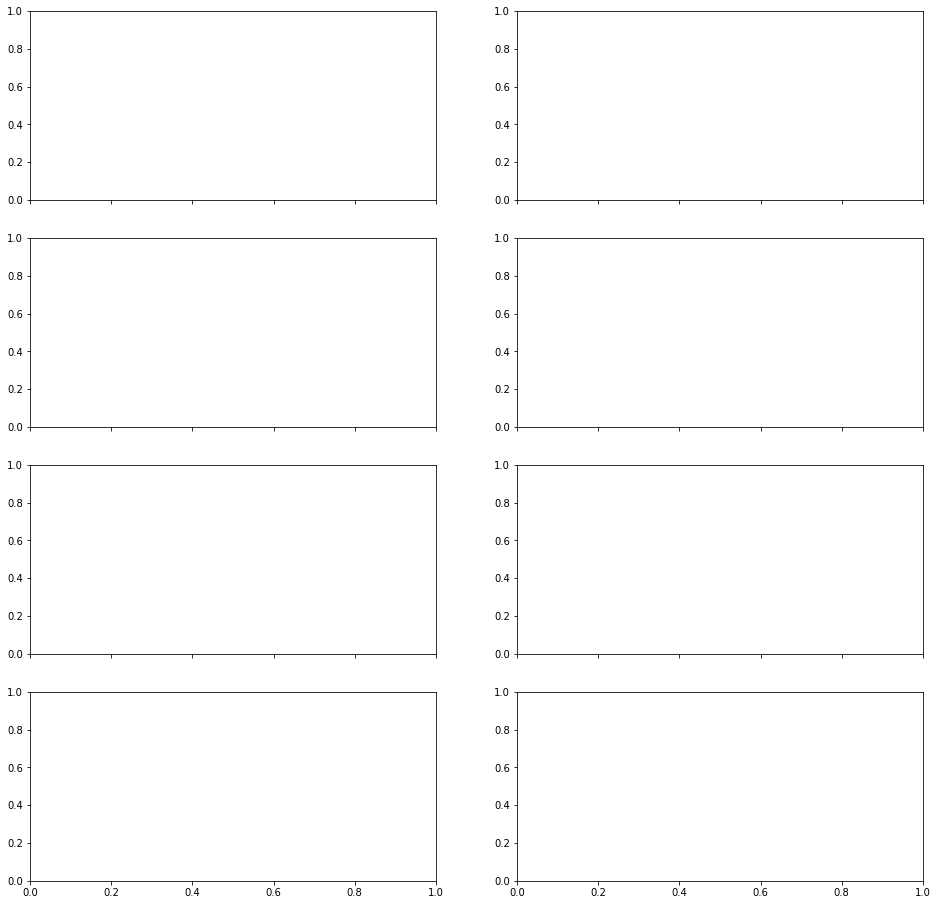

In [7]:
# provide some hyper
n_rows = 4
n_cols = 2

path_to_saving = path_to_summary_results + 'summary_results.pdf'

# create figure
fig, ax = plt.subplots(
    n_rows, 
    n_cols, 
    sharex=True , 
    figsize=(16, n_rows * 4)
)

result_index_counter= 0
# iterate over all considered prediction types
for index_pred, pred_type in enumerate(PRED_TYPE_LIST):
    
    # iterate over all considered parameter constellations
    for index_param, parameter in enumerate(PARAMETER_LIST):

        delta = int(parameter[5])
        valup = int(parameter[12])
        
        # get results df corresponding to currently iterated parameter and pred_type
        result = results_list[result_index_counter]
        
        # increment result index counter
        result_index_counter += 1
        
        # create the column name for random lossess
        col_name_train = (
            pred_type 
            + ' None ' 
            + 'PL ' 
            + 'train'
        )
        col_name_val = (
            pred_type 
            + ' None ' 
            + 'PL ' 
            + 'val'
        )
        
        # get random results
        PL_train = result[col_name_train][9:].dropna().values
        t_iter = int(result[col_name_train][1])

        PL_val = result[col_name_val][9:].dropna().values
        budget_usage = result[col_name_val][2]
        sensor_usage = result[col_name_val][3]
        RF_loss = result[col_name_val][5]
        PL_loss = result[col_name_val][6]
        PL_accuracy = 1 - min(1, PL_loss /RF_loss)
        
        # create the figure legends for random losses
        legend_RF = 'RF baseline'
        legend_PL_train = '{} {}s'.format(
            'PL random:', 
            t_iter
        )
        legend_PL_val = '{}  {:.0%} data  {:.0%} sensors  {:.0%} accuracy'.format(
            'PL random:', 
            budget_usage, 
            sensor_usage,
            PL_accuracy
        )
        
        

In [ ]:
n_rows = 4
n_cols = 2


# create figure
fig, ax = plt.subplots(
    n_rows, 
    n_cols, 
    sharex=True , 
    figsize=(16, n_rows * 4)
)

result_index_counter= 0
# iterate over all considered prediction types
for index_pred, pred_type in enumerate(PRED_TYPE_LIST):
    
    # iterate over all considered parameter constellations
    for index_param, parameter in enumerate(PARAMETER_LIST):

        delta = int(parameter[5])
        valup = int(parameter[12])
        
        # get results df corresponding to currently iterated parameter and pred_type
        result = results_list[result_index_counter]
        
        # increment result index counter
        result_index_counter += 1
        
        # create the column name for random lossess
        col_name_train = (
            pred_type 
            + ' None ' 
            + 'PL ' 
            + 'train'
        )
        col_name_val = (
            pred_type 
            + ' None ' 
            + 'PL ' 
            + 'val'
        )
        
        # get random results
        PL_train = result[col_name_train][9:].dropna().values
        t_iter = int(result[col_name_train][1])

        PL_val = result[col_name_val][9:].dropna().values
        budget_usage = result[col_name_val][2]
        sensor_usage = result[col_name_val][3]
        RF_loss = result[col_name_val][5]
        PL_loss = result[col_name_val][6]
        PL_accuracy = 1 - min(1, PL_loss /RF_loss)
        
        # create the figure legends for random losses
        legend_RF = 'RF baseline'
        legend_PL_train = '{} {}s'.format(
            'PL random:', 
            t_iter
        )
        legend_PL_val = '{}  {:.0%} data  {:.0%} sensors  {:.0%} accuracy'.format(
            'PL random:', 
            budget_usage, 
            sensor_usage,
            PL_accuracy
        )
        
        # iterate over all AL variables
        for index_var, AL_variable in enumerate(AL_VARIABLES):
            
            # plot passive learning losses
            ax[index_var, 0].plot(
                PL_train, 
                color='b', 
                linestyle='--', 
                label=legend_PL_train
            )
            ax[index_var, 1].plot(
                PL_val, 
                color='b', 
                linestyle='--', 
                label=legend_PL_val
            )
            
            if index_var == 0:
                # set column titles
                cols = [
                    'Training losses \n {}'.format(AL_variable), 
                    'Validation losses \n {}'.format(AL_variable)
                ]
                for axes, col in zip(ax[0], cols):
                    axes.set_title(col)
            else:
                
                # set title
                ax[index_var, 0].set_title(AL_variable)
                ax[index_var, 1].set_title(AL_variable)
                       
            # iterate over all AL variants
            for index_method, AL_variant in enumerate(AL_VARIANTS):
                
                # create the column name for iterated validation loss
                col_name_train = (
                    pred_type 
                    + ' ' 
                    + AL_variable 
                    + ' ' 
                    + AL_variant 
                    + ' train'
                )
                col_name_val = (
                    pred_type 
                    + ' ' 
                    + AL_variable 
                    + ' ' 
                    + AL_variant 
                    + ' val'
                )
                
                # get training losses for mode 1 with validation updates
                train_history = result[col_name_train][9:].dropna().values
                t_iter = int(result[col_name_train][1])

                val_history = result[col_name_val][9:].dropna().values
                budget = result[col_name_val][2]
                sensor = result[col_name_val][3]
                RF_loss = result[col_name_val][5]
                AL_loss = result[col_name_val][6]
                AL_accuracy = 1 - min(1, AL_loss /RF_loss)
                
                # create the legends
                legend_train = 'AL {}: {}s'.format(
                    AL_variant, 
                    t_iter
                )
                legend_val = 'AL {}:  {:.0%} data  {:.0%} sensors  {:.0%} accuracy'.format(
                    AL_variant, 
                    budget, 
                    sensor,
                    AL_accuracy
                )
                
                # plot iterated training losses
                ax[index_var, 0].plot(
                    train_history, 
                    label=legend_train
                )
                ax[index_var, 1].plot(
                    val_history, 
                    label=legend_val
                )

            # set legend
            ax[index_var, 0].legend(
                loc='best', 
                frameon=False,
                fontsize=FONTSIZE-2
            )
            ax[index_var, 1].legend(
                loc='best', 
                frameon=False,
                fontsize=FONTSIZE-2
            )

            # set y-axis labels
            ax[index_var, 0].set_ylabel(
                'L2 loss [kW²]', 
                fontsize=FONTSIZE+3
            )
            
            
        # set x-axis
        ax[index_var, 0].set_xlabel(
            'epoch', 
            fontsize=FONTSIZE+3
        )
        ax[index_var, 1].set_xlabel(
            'epoch', 
            fontsize=FONTSIZE+3
        )

## 10. Manuscript: Data selection maps

In [10]:
%%capture 
# prevents figures being printed out if used at begining of cell


# define some hyper for plots
n_rows = 3
n_cols = 2
n_iter_plot = n_rows * n_cols - 1
n_meshes_surface = 10
FONTSIZE = 22

# import building meta data
path_to_building_meta = '../data/private/' + profile_set + '/meta/meta buildings.csv'
building_meta = pd.read_csv(path_to_building_meta)

def create_bottom_plot(df_initial_sensors):

    # get bound coordinates of all buildings
    min_lat = df_initial_sensors['building lat'].min()
    max_lat = df_initial_sensors['building lat'].max() 
    min_long = df_initial_sensors['building long'].min()
    max_long = df_initial_sensors['building long'].max()

    # create evenly sized arrays and meshed grid of lats and longs
    lat_surface = np.linspace(
        min_lat, 
        max_lat,
        num=n_meshes_surface
    )
    long_surface = np.linspace(
        min_long, 
        max_long,
        num=n_meshes_surface
    )
    long_surface, lat_surface  = np.meshgrid(long_surface, lat_surface)
    
    map_height = 0
    Z = np.full((len(lat_surface), 1), map_height)
    
    ax.scatter(
        df_initial_sensors['building long'], 
        df_initial_sensors['building lat'], 
        map_height,  
        alpha=1, marker='x', c='r', s=100
    ) 
    ax.plot_surface(
        long_surface, 
        lat_surface, 
        Z,  
        alpha=0.03
    )
    ax.set_zlim(map_height)
    
def create_plot(time_data, df, df_new_sensors):
    
    # get bound coordinates of all buildings
    min_lat = df['building lat'].min()
    max_lat = df['building lat'].max() 
    min_long = df['building long'].min()
    max_long = df['building long'].max()

    # create evenly sized arrays and meshed grid of lats and longs
    lat_surface = np.linspace(
        min_lat, 
        max_lat,
        num=n_meshes_surface
    )
    long_surface = np.linspace(
        min_long, 
        max_long,
        num=n_meshes_surface
    )
    long_surface, lat_surface  = np.meshgrid(long_surface, lat_surface)
    
    # update max time point
    min_time_point, max_time_point = min(time_data), max(time_data)
    map_height = max_time_point/3 * (1 + 3* iteration/n_iter_plot)
    shifting_time = max_time_point - map_height
    Z = np.full((len(lat_surface), 1), map_height)
    
    ax.scatter(
        df['building long'], 
        df['building lat'], 
        time_data - shifting_time, 
        c=time_data, alpha=0.7
    )
    ax.scatter(
        df_new_sensors['building long'], 
        df_new_sensors['building lat'], 
        map_height,  
        alpha=1, marker='x', c='r', s=100
    )
    ax.plot_surface(
        long_surface, 
        lat_surface, 
        Z,  
        alpha=0.03
    )
    ax.set_zlim(min_time_point - shifting_time, max_time_point)
    

def customize_plot(iteration):
    
    # set angle
    ax.view_init(30, 110)
    
    # Get rid of the panes
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # Get rid of the ticks
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])

    # Add the labels
    ax.set_xlabel('long', fontsize=FONTSIZE)
    ax.set_ylabel('lat', fontsize=FONTSIZE)
    ax.set_zlabel('time', fontsize=FONTSIZE)

    # shift time (z) axis
    tmp_planes = ax.zaxis._PLANES 
    ax.zaxis._PLANES = ( 
        tmp_planes[2], tmp_planes[3], 
        tmp_planes[0], tmp_planes[1], 
        tmp_planes[4], tmp_planes[5]
    )
    
    # shift lat (y) axis
    ax.yaxis._PLANES = ( 
        tmp_planes[2], tmp_planes[3], 
        tmp_planes[0], tmp_planes[1], 
        tmp_planes[4], tmp_planes[5]
    )
    
    
    # set subplot titles
    ax.set_title(
        fig_title_list[plot_counter-1].format(iteration+1), 
        fontsize=FONTSIZE + 4
    )


# create a counter over the list of numeric results
result_index_counter = 0

# iterate over all considered prediction types
for index_pred, pred_type in enumerate(PRED_TYPE_LIST):
    
    # iterate over all considered parameter constellations
    for index_param, parameter in enumerate(PARAMETER_LIST):
        
        # get results df corresponding to currently iterated parameter and pred_type
        spacetime_result = spacetime_selection_list[result_index_counter]

        # increment result index counter
        result_index_counter += 1
        
        for AL_variable in AL_VARIABLES:
            
            for AL_variant in AL_VARIANTS:
        
                # create figure
                fig = plt.figure(figsize=(16, n_rows * 8))

                # set the fontsize for figures
                mpl.rcParams.update({'font.size': 16}) #FONTSIZE

                colname_initial_sensors = '{} - initial sensors'.format(pred_type)
                intial_sensors = spacetime_result[colname_initial_sensors]
                df_initial_sensors = pd.DataFrame({'building ID':intial_sensors})
                df_initial_sensors = df_initial_sensors.merge(building_meta, on='building ID', how='left')
                
                plot_counter= 1
                ax = fig.add_subplot(n_rows, n_cols, plot_counter, projection='3d')
                create_bottom_plot(df_initial_sensors)
                customize_plot(iteration=0)
                plot_counter += 1
                old_senors_AL_set = set(intial_sensors)
                old_senors_PL_set = set(intial_sensors)
                for iteration in range(n_iter_plot):

                    # create column names
                    colname_AL_times = '{} {} {} - iter {} time'.format(pred_type, AL_variable, AL_variant, iteration) 
                    colname_AL_spaces = '{} {} {} - iter {} space'.format(pred_type, AL_variable, AL_variant, iteration) 
                    
                    ### Plot AL results on left column ###
                    
                    # get data
                    space_data_AL = spacetime_result[colname_AL_spaces]
                    time_data_AL = spacetime_result[colname_AL_times]

                    # get new sensors and set old sensors
                    new_sensors_AL_set = set(space_data_AL).union(old_senors_AL_set)
                    new_sensors_AL_list = list(new_sensors_AL_set - old_senors_AL_set)
                    old_senors_AL_set = new_sensors_AL_set
                    
                    # assign lat and long to building IDs
                    df_AL = pd.DataFrame({'building ID':space_data_AL})
                    df_AL = df_AL.merge(building_meta, on='building ID', how='left')

                    df_new_sensors_AL = pd.DataFrame({'building ID':new_sensors_AL_list})
                    df_new_sensors_AL = df_new_sensors_AL.merge(building_meta, on='building ID', how='left')

                    # AL temporal scatter plot
                    ax = fig.add_subplot(n_rows, n_cols, plot_counter, projection='3d')
                    create_plot(time_data_AL, df_AL, df_new_sensors_AL)
                    customize_plot(iteration)
                    plot_counter += 1

                # create saving paths 
                saving_path = (
                    path_to_ADL_selection 
                    + pred_type
                    + ' '
                    + parameter
                    + ' '
                    + AL_variable
                    + ' '
                    + AL_variant
                    + '.pdf'
                )

                # create a legend
                legend_elements = [
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='query in space-time'),
                    Line2D([0], [0], marker='X', color='w', markerfacecolor='r', markersize=15, label='new sensor in space')
                ]

                # set layout tight
                fig.tight_layout()

                fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.6, 1), fontsize=FONTSIZE)

                # save figures
                fig.savefig(saving_path, bbox_inches="tight")

TypeError: object of type 'NoneType' has no len()

KeyboardInterrupt: 